In [648]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import re
import unicodedata
from torch.utils.data import Dataset, TensorDataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [443]:
# load data
train_df = pd.read_csv('data/train.csv')

# train validation split
from sklearn.model_selection import train_test_split
train_df, validation_df = train_test_split(train_df, test_size=0.2)

In [444]:
train_df.head()

,Class Index,Title,Description
48964,3,Nintendo Raises Net Profit Estimate,OSAKA (Reuters) - Japanese game maker Nintend...
36810,3,Computer Associates settles charges; ex-CEO in...,"NEW YORK, September 23 (newratings.com) - The ..."
112401,1,Maathai accepts Nobel Peace Prize,The first African woman to win the Nobel Peace...
93739,1,India ; No division of Kashmir on basis of rel...,He was reacting to a question on Musharraf #39...
79016,3,St George lifted by lending,ST GEORGE Bank has continued to post big gains...


In [445]:
# data normalization
train = []
for sentence in list(train_df.Description):
    sentence = re.sub('\.', ' ', sentence)
    sentence = re.sub('-', ' ', sentence)
    sentence = re.sub('\\\\', ' ', sentence)
    sentence = sentence.lower()
    sentence = unicodedata.normalize('NFD', sentence)
    sentence = re.sub('[^a-z0 ]', '', sentence)
    sentence = sentence.strip()        
    words = re.split(' ', sentence)
    words = [w for w in words if w]
    train += [words]

In [446]:
# create vocabulary
vocab = []
for words in train:
    vocab += words
vocab = list(set(vocab))
v_size = len(vocab)

In [447]:
# create vocab hash table for fast indexing
lookup = {}
for i in range(len(vocab)):
    lookup[vocab[i]] = i

In [448]:
# calculate co-occurence counts
counts = {}
w_size = 3

for words in train:
    for i in range(0, len(words)):
        for j in range(max(i-w_size,0), min(i+w_size,len(words))):
            if j != i:
                key = (lookup[words[i]], lookup[words[j]])
                counts[key] = counts.setdefault(key, 0) + 1
len(counts)               

3668966

In [450]:
# GloVe model
e_size = 100
b_size = 2048
    
class glove(nn.Module):
    def __init__(self, v_size, e_size):
        super().__init__()
        self.V = nn.Embedding(v_size, e_size, sparse=False)
        self.V_bias = nn.Parameter(torch.zeros((v_size,1)))
        self.U = nn.Embedding(v_size, e_size, sparse=False)
        self.U_bias = nn.Parameter(torch.zeros((v_size,1)))
        self.h = lambda x: torch.min(torch.vstack(((x/100)**0.75, torch.ones(x.shape[0]))), dim=0).values
    
    def forward(self, data):
        b_size = data[0].shape[0]
        c = data[0][:,0]
        o = data[0][:,1]
        v = self.V(c)
        u = self.U(o)
        f = torch.sum((u * v), dim=1) + self.V_bias[c].flatten() + self.U_bias[o].flatten()   
        count = torch.empty(b_size)
        for i in range(b_size):
            count[i] = counts[(c[i].item(), o[i].item())]
        loss = self.h(count)*(f - np.log(count))**2
        return loss.sum()

In [451]:
dataset = TensorDataset(torch.tensor(list(counts.keys())))
loader = DataLoader(dataset, shuffle=True, batch_size = b_size)
model = glove(v_size, e_size)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [453]:
# train GloVe embeddings
model.train()
for epoch in range(10):
    running_loss = 0.0
    for i, data in enumerate(loader, 0):
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        loss = model(data)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 500 == 499:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 500:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,   500] loss: 8434.056
[1,  1000] loss: 3728.835
[1,  1500] loss: 2171.787
[2,   500] loss: 927.213
[2,  1000] loss: 832.745
[2,  1500] loss: 729.922
[3,   500] loss: 881.794
[3,  1000] loss: 821.969
[3,  1500] loss: 770.503
[4,   500] loss: 784.686
[4,  1000] loss: 714.730
[4,  1500] loss: 657.785
[5,   500] loss: 605.468
[5,  1000] loss: 559.510
[5,  1500] loss: 519.585
[6,   500] loss: 499.285
[6,  1000] loss: 454.487
[6,  1500] loss: 422.302
[7,   500] loss: 432.860
[7,  1000] loss: 392.943
[7,  1500] loss: 368.777
[8,   500] loss: 374.967
[8,  1000] loss: 341.585
[8,  1500] loss: 312.100
[9,   500] loss: 330.571
[9,  1000] loss: 297.644
[9,  1500] loss: 276.138
[10,   500] loss: 292.460
[10,  1000] loss: 261.192
[10,  1500] loss: 242.679
Finished Training


In [480]:
# get word embeddings
embeddings = model.V.weight.detach().numpy() + model.U.weight.detach().numpy()
embeddings.shape

(58339, 100)

In [455]:
# create 2D projections
tsne = TSNE(n_components=2, random_state=0)
two_d_embeddings = tsne.fit_transform(embeddings)

C:\Users\simon\anaconda3\envs\MachineLearning\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\simon\anaconda3\envs\MachineLearning\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


In [599]:
# plot projections
def visualize_embeddings(two_d_embeddings, words):
    plt.figure(figsize=(7, 7))
    for i, word in enumerate(words):
        x, y = two_d_embeddings[i, :]
        plt.scatter(x, y)
        plt.annotate(word, (x, y), xytext=(5, 2), textcoords="offset points", ha="right", va="bottom")
    plt.show()

In [594]:
lookup["seoul"]

30467

In [595]:
# visualize a selection of words from different topics
indexlist = [49697,41511,19547,41801,38394,7904,29812,11234,31590,30467,
             23545, 21528, 35751,
             12678,2263]

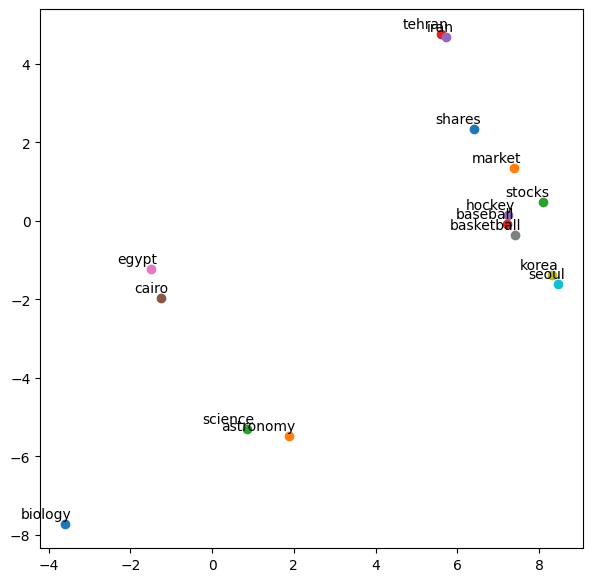

In [600]:
visualize_embeddings(two_d_embeddings[indexlist], np.asarray(vocab)[indexlist])

In [601]:
# calculate Euclidean distance between word embeddings
def distance(a, b):
    return np.linalg.norm(embeddings[lookup[a]] - embeddings[lookup[b]])

In [654]:
distance('biology', 'baseball')

6.847945

In [608]:
# create sentence embeddings by averaging over word embeddings
sentence_embeddings = np.zeros((len(train), e_size))
for i, sentence in enumerate(train):
    for word in sentence:
        sentence_embeddings[i] += embeddings[lookup[word]]
    sentence_embeddings[i] /= len(sentence)

In [628]:
class SentenceDataset(Dataset):
    def __init__(self, embeddings):
        self.sentence_embeddings = torch.tensor(embeddings).to(torch.float32)

    def __len__(self):
        return len(self.sentence_embeddings)

    def __getitem__(self, idx):
        return self.sentence_embeddings[idx], np.asarray(train_df['Class Index'])[idx]-1

In [629]:
# topic classifier model
topic_classifier = nn.Sequential(
          nn.Linear(e_size, 256),
          nn.ReLU(),
          nn.Linear(256, 512),
          nn.ReLU(),
          nn.Linear(512, 256),
          nn.ReLU(),
          nn.Linear(256, 4),
        )

In [627]:
np.asarray(train_df['Class Index'])

array([3, 3, 1, ..., 2, 4, 3], dtype=int64)

In [630]:
s_dataset = SentenceDataset(sentence_embeddings)
s_loader = DataLoader(s_dataset, shuffle=True, batch_size = 64)
optimizer = torch.optim.Adam(topic_classifier.parameters())
criterion = nn.CrossEntropyLoss()

In [631]:
# train topic classifier model
topic_classifier.train()
for epoch in range(3):
    running_loss = 0.0
    for i, data in enumerate(s_loader, 0):
        
        embedding, labels = data
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        out = topic_classifier(embedding)
        loss = criterion(out, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 600 == 599:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 600:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,   600] loss: 0.667
[1,  1200] loss: 0.591
[2,   600] loss: 0.539
[2,  1200] loss: 0.531
[3,   600] loss: 0.495
[3,  1200] loss: 0.500
Finished Training


In [634]:
# clean validation data
val = []
for sentence in list(validation_df.Description):
    sentence = re.sub('\.', ' ', sentence)
    sentence = re.sub('-', ' ', sentence)
    sentence = re.sub('\\\\', ' ', sentence)
    sentence = sentence.lower()
    sentence = unicodedata.normalize('NFD', sentence)
    sentence = re.sub('[^a-z0 ]', '', sentence)
    sentence = sentence.strip()        
    words = re.split(' ', sentence)
    words = [w for w in words if w in lookup]
    val += [words]

In [635]:
val_sentence_embeddings = np.zeros((len(val), e_size))
for i, sentence in enumerate(val):
    for word in sentence:
        val_sentence_embeddings[i] += embeddings[lookup[word]]
    val_sentence_embeddings[i] /= len(sentence)

C:\Users\simon\AppData\Local\Temp\ipykernel_7824\2657220331.py:5: RuntimeWarning: invalid value encountered in true_divide
  val_sentence_embeddings[i] /= len(sentence)


In [636]:
# evaluate model on validation set
val_out = topic_classifier(torch.tensor(val_sentence_embeddings).to(torch.float32)).detach().numpy()

In [638]:
(np.argmax(val_out, axis=1) == (np.asarray(validation_df['Class Index'])-1)).mean()

0.810625

In [639]:
# clean test data
test_df = pd.read_csv('data/test.csv')
test = []
for sentence in list(test_df.Description):
    sentence = re.sub('\.', ' ', sentence)
    sentence = re.sub('-', ' ', sentence)
    sentence = re.sub('\\\\', ' ', sentence)
    sentence = sentence.lower()
    sentence = unicodedata.normalize('NFD', sentence)
    sentence = re.sub('[^a-z0 ]', '', sentence)
    sentence = sentence.strip()        
    words = re.split(' ', sentence)
    words = [w for w in words if w in lookup]
    test += [words]

In [640]:
test_sentence_embeddings = np.zeros((len(test), e_size))
for i, sentence in enumerate(test):
    for word in sentence:
        test_sentence_embeddings[i] += embeddings[lookup[word]]
    test_sentence_embeddings[i] /= len(sentence)

In [641]:
# evaluate model on test set
test_out = topic_classifier(torch.tensor(test_sentence_embeddings).to(torch.float32)).detach().numpy()

In [642]:
(np.argmax(test_out, axis=1) == (np.asarray(test_df['Class Index'])-1)).mean()

0.8068421052631579

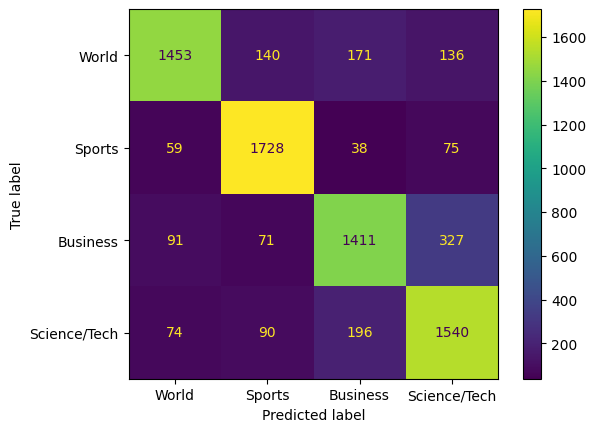

In [650]:
# confusion matrix
cm = confusion_matrix(np.asarray(test_df['Class Index'])-1, np.argmax(test_out, axis=1))
visual = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ['World', 'Sports', 'Business', 'Science/Tech'])
visual.plot()
plt.show()